<a href="https://colab.research.google.com/github/MuhammedAshraf2020/yolo_using_pytorch/blob/main/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CONVERT JSON ANNOTATION TO TXT FILES

In [1]:
from google.colab import drive
drive.mount("Drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4131EMlsqnXfJR9UJdMot6msvWjkr5KgkIpjzE8CDWIdx3XFjQZdo
Mounted at Drive


In [2]:
!cp /content/Drive/MyDrive/VOC/VOCtest_06-Nov-2007.tar /content

In [ ]:
!tar -xvf /content/VOCtest_06-Nov-2007.tar

In [14]:
!python annotate_txt.py /content/VOCdevkit/VOC2007/Annotations /content/train

100% 4952/4952 [00:00<00:00, 7889.22it/s]


In [13]:
!rm -r /content/train

In [17]:
!python create_csv.py /content/train /content/VOCdevkit/VOC2007/JPEGImages

524it [00:01, 486.87it/s]
225it [00:00, 503.77it/s]


In [15]:
import os
len(os.listdir("/content/train"))

749

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from utils import *
import torch.nn as nn
from model import Yolov1
from tqdm import tqdm
from loss import YoloLoss
import torch.optim as optim
from custom import VocDataSet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision



class Compose(object):
	def __init__(self , transforms):
		self.transforms = transforms

	def __call__(self , img , boxes):
		for trans in self.transforms:
			img , boxes = (trans(img) , boxes)

		return img , boxes

transform = Compose([transforms.Resize((448 , 448)) , transforms.ToTensor()])


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOAD_MODEL_FILE = "overfit.pth.tar"
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 0 
BATCH_SIZE    = 16
NUM_WORKERS   = 2
PIN_MEMORY    = True
EPOCHS        = 1000
LOAD_MODEL    = False
print("-> Device        is {}".format(DEVICE))
print("-> Epochs        is {}".format(EPOCHS))
print("-> Batch size    is {}".format(BATCH_SIZE))
print("-> Pin Memory    is {}".format(PIN_MEMORY))
print("-> Num Workers   is {}".format(NUM_WORKERS))
print("-> Weight decay  is {}".format(WEIGHT_DECAY))
print("-> Learning rate is {}".format(LEARNING_RATE))


def plot_image(image, boxes):
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle((upper_left_x * width, upper_left_y * height),box[2] * width,box[3] * height,linewidth=1,edgecolor="r",facecolor="none",)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def train(loader , model , optimizer , loss_fn):
	mean_loss = []
	loop = tqdm(loader , leave = True)
	for batch_idx , (x , y) in enumerate(loop):
		x    = x.to(DEVICE)
		y    = y.to(DEVICE)
		out  = model(x)
		loss = loss_fn(out , y)
		mean_loss.append(loss.item())
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		loop.set_postfix(loss = loss.item())
	print("\nMean Loss is {}".format(sum(mean_loss) / len(mean_loss)))


-> Device        is cuda
-> Epochs        is 1000
-> Batch size    is 16
-> Pin Memory    is True
-> Num Workers   is 2
-> Weight decay  is 0
-> Learning rate is 0.001


In [3]:
!cp /content/Drive/MyDrive/model.pth /content

In [5]:
from model import Yolov1
from model import DarkLayer
import torch.nn as nn

model = Yolov1(3 , S = 7 , B = 2 , C = 2).to(DEVICE)

pretrain_classifier = nn.Sequential(
				nn.Flatten() ,
				nn.Linear( 25088 * 2, 1024) ,
				nn.ReLU() ,
				nn.Dropout(0.4)  ,
				nn.Linear(1024 , 256) , 
        nn.ReLU() ,
        nn.Linear(256 , 2) ,
        nn.Softmax(1),
	) 


model.fcs = pretrain_classifier

optimizer = optim.Adam(model.parameters() , lr = LEARNING_RATE)
loss_fn   = nn.CrossEntropyLoss()

model.load_state_dict(torch.load( "model.pth"))

layers = []
for layer in model.darknet:
  layers.append(layer)

layers.append(DarkLayer(in_channels = 1024 , out_channels = 1024 , kernel_size = 3 ,  stride = 1 , padding = 1))
layers.append(DarkLayer(in_channels = 1024 , out_channels = 1024 , kernel_size = 3 , stride = 1 , padding = 1))
layers.append(DarkLayer(in_channels = 1024 , out_channels = 1024 , kernel_size = 3 , stride = 2 , padding = 1))
layers.append(DarkLayer(in_channels = 1024 , out_channels = 1024 , kernel_size = 3 , stride = 1 , padding = 1))

model.darknet = nn.Sequential(*layers)

S = 7 
B = 2
C = 2
model.fcs = nn.Sequential(nn.Flatten() , 
							 nn.Linear(1024 * S * S , 496) ,
							 nn.Dropout(0.3) ,
							 nn.LeakyReLU(0.1) ,
							 nn.Linear(496 , S * S * ( C + B * 5)))
model = model.to("cuda")

index = 0
for param in model.parameters():
  if index == 59:
    break
  index += 1
  param.requires_grad = False

In [ ]:
Model      = model.to("cuda")
optimizer  = optim.Adam(Model.parameters() , lr = LEARNING_RATE , weight_decay = WEIGHT_DECAY)
loss_fn    = YoloLoss(S = 7 , B  = 2 , C = 2)
train_data = VocDataSet("train.csv" , transform  = transform  , S = 7  , B = 2 , C = 2)
test_data  = VocDataSet("test.csv"  , transform  = transform  , S = 7  , B = 2 , C = 2)
train_load = DataLoader(train_data  , batch_size = BATCH_SIZE , pin_memory = PIN_MEMORY , shuffle = True , num_workers = NUM_WORKERS)
test_load  = DataLoader(test_data   , batch_size = BATCH_SIZE , pin_memory = PIN_MEMORY , shuffle = True , num_workers = NUM_WORKERS)

for epoch in range(EPOCHS):
  pred_boxes , target_boxes = get_bbox(train_load  , Model , iou_threshold = 0.4 , prob_threshold = 0.5)
  mAP = mean_average_precision(pred_boxes , target_boxes , iou_threshold = 0.4)
  print("mAP : {}".format(mAP))
  train(train_load , Model , optimizer , loss_fn)
  

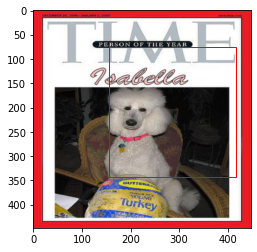

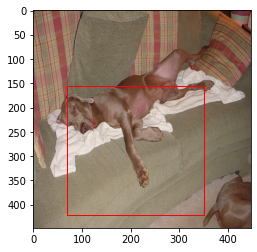

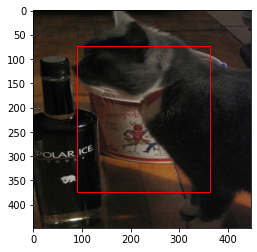

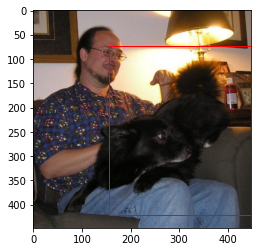

In [27]:
for x, y in test_load:
  x = x.to(DEVICE)
  for idx in range(4):
    bboxes = cellboxes_to_boxes(Model(x))
    bboxes = non_max_suppression(bboxes[idx], iou_threshold = 0.3, prob_threshold=0.4, box_format="midpoints")
    plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
  break